# 7. Neural Machine Translation and Models with Attention

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture9.pdf
* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture10.pdf
* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture11.pdf
* https://arxiv.org/pdf/1409.0473.pdf
* https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
* https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983
* http://www.manythings.org/anki/

In [1]:
import mindspore
from mindspore import nn, Tensor, ops, Parameter
import random
import numpy as np
import os
import re
import unicodedata
from mindnlp.modules import Accumulator
flatten = lambda l: [item for sublist in l for item in sublist]
from mindspore.common.initializer import initializer

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
random.seed(1024)
%matplotlib inline

[WARNING] ME(1103492:139665709524800,MainProcess):2023-07-09-11:39:09.399.390 [mindspore/run_check/_check_version.py:102] MindSpore version 2.0.0.20230623 and cuda version 11.7.60 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.
/home/daiyuxin/anaconda3/envs/cjh1/lib/python3.7/site-packages/mindnlp/utils/download.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
gpu = '0'
# 设置使用哪些显卡进行训练
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

In [3]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

### Padding

<img src="../images/07.pad_to_sequence.png">
<center>borrowed image from https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983</center>

In [4]:
# It is for Sequence 2 Sequence format
def pad_to_batch(batch, x_to_ix, y_to_ix):

    sorted_batch = sorted(batch, key=lambda b: b[0].shape[1], reverse=True)  # sort by len
    x, y = list(zip(*sorted_batch))
    max_x = max([s.shape[1] for s in x])
    max_y = max([s.shape[1] for s in y])
    x_p, y_p = [], []
    for i in range(len(batch)):
        if x[i].shape[1] < max_x:
            x_p.append(ops.cat([x[i], Parameter(Tensor([x_to_ix['<PAD>']] * (max_x - x[i].shape[1]), dtype=mindspore.int64)).view(1, -1)], 1))
        else:
            x_p.append(x[i])
        if y[i].shape[1] < max_y:
            y_p.append(ops.cat([y[i], Parameter(Tensor([y_to_ix['<PAD>']] * (max_y - y[i].shape[1]), dtype=mindspore.int64)).view(1, -1)], 1))
        else:
            y_p.append(y[i])

    input_var = ops.cat(x_p)
    target_var = ops.cat(y_p)
    input_len = [list(map(lambda s: s == 0, t.asnumpy())).count(False) for t in input_var]
    target_len = [list(map(lambda s: s == 0, t.asnumpy())).count(False) for t in target_var]

    return input_var, target_var, input_len, target_len

In [5]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w]
                    if word2index.get(w) is not None
                    else word2index["<UNK>"], seq))
    sequence = Tensor(idxs, dtype=mindspore.int64)
    return sequence

## Data load and Preprocessing 

Borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

In [6]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

<center><h3>French -> English</h3></center>

In [7]:
corpus = open('../dataset/eng-fra.txt', 'r', encoding='utf-8').readlines()

In [8]:
len(corpus)

217975

In [9]:
corpus = corpus[:30000]  # for practice

In [10]:
MIN_LENGTH = 3
MAX_LENGTH = 25

In [11]:
%%time
X_r, y_r = [], []  # raw

for parallel in corpus:
    so, ta, _ = parallel[:-1].split('\t')
    if so.strip() == "" or ta.strip() == "":
        continue

    normalized_so = normalize_string(so).split()
    normalized_ta = normalize_string(ta).split()

    if len(normalized_so) >= MIN_LENGTH and len(normalized_so) <= MAX_LENGTH \
        and len(normalized_ta) >= MIN_LENGTH \
            and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)


print(len(X_r), len(y_r))
print(X_r[0], y_r[0])

29459 29459
['i', 'see', '.'] ['je', 'comprends', '.']
CPU times: user 817 ms, sys: 20.7 ms, total: 837 ms
Wall time: 837 ms


### Build Vocab

In [12]:
source_vocab = list(set(flatten(X_r)))
target_vocab = list(set(flatten(y_r)))
print(len(source_vocab), len(target_vocab))

4266 7439


In [13]:
source2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in source_vocab:
    if source2index.get(vo) is None:
        source2index[vo] = len(source2index)
index2source = {v: k for k, v in source2index.items()}

target2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in target_vocab:
    if target2index.get(vo) is None:
        target2index[vo] = len(target2index)
index2target = {v: k for k, v in target2index.items()}

### Prepare train data

In [14]:
%%time
X_p, y_p = [], []

for so, ta in zip(X_r, y_r):
    X_p.append(prepare_sequence(so + ['</s>'], source2index).view(1, -1))
    y_p.append(prepare_sequence(ta + ['</s>'], target2index).view(1, -1))

train_data = list(zip(X_p, y_p))

CPU times: user 8.12 s, sys: 1.23 s, total: 9.34 s
Wall time: 6.85 s


## Modeling 

<img src="../images/07.seq2seq.png">
<center>borrowd image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture10.pdf</center>

If you're not familier with <strong>pack_padded_sequence</strong> and <strong>pad_packed_sequence</strong>, check this <a href="https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983">post</a>.

In [15]:
class Encoder(nn.Cell):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, bidirec=False):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, embedding_size, embedding_table="XavierUniform")

        if bidirec:
            self.n_direction = 2
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)

    def init_hidden(self, inputs):
        hidden = Parameter(ops.zeros((self.n_layers * self.n_direction, inputs.shape[0], self.hidden_size)))
        return hidden

    def init_weight(self, embedding_size, hidden_size):
        self.gru.weight_ih = initializer('XavierUniform', [embedding_size, hidden_size])
        self.gru.weight_hh = initializer('XavierUniform', [embedding_size, hidden_size])

    def construct(self, inputs, input_lengths):
        """
        inputs : B, T (LongTensor)
        input_lengths : real lengths of input batch (list)
        """
        hidden = self.init_hidden(inputs)
        embedded = self.embedding(inputs)
        input_lengths = Tensor(input_lengths).astype(mindspore.int32)

        outputs, hidden = self.gru(embedded, hidden, input_lengths)

        if self.n_layers > 1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]
        h_last = ops.cat(list(hidden), 1)
        h_last = h_last.unsqueeze(1)
        return outputs, h_last

### Attention Mechanism ( https://arxiv.org/pdf/1409.0473.pdf )

I used general-type for score function $h_t^TW_ah_s^-$

<img src="../images/07.attention-mechanism.png">
<center>borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture10.pdf</center>

In [16]:
class Decoder(nn.Cell):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define the layers
        self.embedding = nn.Embedding(input_size, embedding_size, embedding_table="XavierUniform")
        self.dropout = nn.Dropout(p=dropout_p)

        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)
        self.dense = nn.Dense(hidden_size * 2, input_size, weight_init="XavierUniform")
        self.attn = nn.Dense(self.hidden_size, self.hidden_size, weight_init="XavierUniform")  # Attention

    def init_hidden(self, inputs):
        hidden = Parameter(ops.zeros((self.n_layers, inputs.shape[0], self.hidden_size)))
        return hidden

    def init_weight(self, embedding_size, hidden_size):
        self.gru.weight_ih = initializer('XavierUniform', [embedding_size, hidden_size])
        self.gru.weight_hh = initializer('XavierUniform', [embedding_size, hidden_size])

    def Attention(self, hidden, encoder_outputs, encoder_maskings):
        """
        hidden : 1,B,D
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        """
        hidden = hidden[0].unsqueeze(2)   # (1,B,D) -> (B,D,1)

        batch_size = encoder_outputs.shape[0]  # B
        max_len = encoder_outputs.shape[1]  # T
        energies = self.attn(encoder_outputs.view(batch_size * max_len, -1))  # B*T,D -> B*T,D
        energies = energies.view(batch_size, max_len, -1)  # B,T,D
        attn_energies = ops.BatchMatMul()(energies, hidden).squeeze(2)  # B,T,D * B,D,1 --> B,T

        alpha = ops.softmax(attn_energies, 1)  # B,T
        alpha = alpha.unsqueeze(1)  # B,1,T
        context = ops.BatchMatMul()(alpha, encoder_outputs)  # B,1,T * B,T,D => B,1,D

        return context, alpha

    def construct(self, inputs, context, max_length, encoder_outputs, encoder_maskings=None, is_training=False):
        """
        inputs : B,1 (LongTensor, START SYMBOL)
        context : B,1,D (FloatTensor, Last encoder hidden state)
        max_length : int, max length to decode # for batch
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        is_training : bool, this is because adapt dropout only training step.
        """
        # Get the embedding of the current input word
        embedded = self.embedding(inputs)
        hidden = self.init_hidden(inputs)
        if is_training:
            embedded = self.dropout(embedded)

        decode = []
        # Apply GRU to the output so far
        for i in range(max_length):

            _, hidden = self.gru(ops.cat((embedded, context), 2), hidden)  # h_t = f(h_{t-1},y_{t-1},c)
            concated = ops.cat((hidden, ops.transpose(context, (1, 0, 2))), 2)  # y_t = g(h_t,y_{t-1},c)
            score = self.dense(concated.squeeze(0))
            softmaxed = ops.log_softmax(score, 1)
            softmaxed = Tensor(softmaxed, dtype=mindspore.float32)
            decode.append(softmaxed)
            decoded = ops.max(softmaxed, 1)[1]
            embedded = self.embedding(decoded).unsqueeze(1)  # y_{t-1}
            if is_training:
                embedded = self.dropout(embedded)

            # compute next context vector using attention
            context, alpha = self.Attention(hidden, encoder_outputs, encoder_maskings)

        #  column-wise concat, reshape!!
        scores = ops.cat(decode, 1)
        return scores.view(inputs.shape[0] * max_length, -1)

    def decode(self, context, encoder_outputs):
        start_decode = Parameter(ops.transpose(Tensor([[target2index['<s>']] * 1], dtype=mindspore.int64), (1, 0)))
        embedded = self.embedding(start_decode)
        hidden = self.init_hidden(start_decode)

        decodes = []
        attentions = []
        decoded = embedded
        while decoded.asnumpy().item(0) != target2index['</s>']:  # until </s>
            _, hidden = self.gru(ops.cat((embedded, context), 2), hidden)  # h_t = f(h_{t-1},y_{t-1},c)
            concated = ops.cat((hidden, ops.transpose(context, (1, 0, 2))), 2)  # y_t = g(h_t,y_{t-1},c)
            score = self.dense(concated.squeeze(0))
            softmaxed = ops.log_softmax(score, 1)
            softmaxed = Tensor(softmaxed, dtype=mindspore.float32)
            decodes.append(softmaxed)
            decoded = ops.max(softmaxed, 1)[1]
            embedded = self.embedding(decoded).unsqueeze(1)  # y_{t-1}
            context, alpha = self.Attention(hidden, encoder_outputs, None)
            attentions.append(alpha.squeeze(1))

        return ops.max(ops.cat(decodes), 1)[1], ops.cat(attentions)

## Train 

It takes for a while if you use just cpu....

In [17]:
EPOCH = 50
BATCH_SIZE = 64
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
LR = 0.001
DECODER_LEARNING_RATIO = 5.0
RESCHEDULED = False

In [18]:
encoder = Encoder(len(source2index), EMBEDDING_SIZE, HIDDEN_SIZE, 3, True)
decoder = Decoder(len(target2index), EMBEDDING_SIZE, HIDDEN_SIZE * 2)
encoder.init_weight(EMBEDDING_SIZE, HIDDEN_SIZE)
decoder.init_weight(EMBEDDING_SIZE, HIDDEN_SIZE)

loss_function = nn.CrossEntropyLoss(ignore_index=0)
enc_optimizer = nn.Adam(encoder.trainable_params(), learning_rate=LR)
dec_optimizer = nn.Adam(decoder.trainable_params(), learning_rate=LR * DECODER_LEARNING_RATIO)

In [19]:
accumulate_step = 2
accumulator_encoder = Accumulator(enc_optimizer, accumulate_step)
accumulator_decoder = Accumulator(dec_optimizer, accumulate_step)


def forward_fn(batch, is_training):
    """Forward function"""
    inputs, targets, input_lengths, target_lengths = pad_to_batch(batch, source2index, target2index)

    input_masks = ops.cat([Tensor(tuple(map(lambda s: s == 0, t.asnumpy())), dtype=mindspore.byte) for t in inputs]).view(inputs.shape[0], -1)
    start_decode = ops.transpose(Tensor([[target2index['<s>']] * targets.shape[0]], dtype=mindspore.int64), (1, 0))

    output, hidden_c = encoder(inputs, input_lengths)
    preds = decoder(start_decode, hidden_c, targets.shape[1], output, input_masks, is_training)
    targets = targets.astype(mindspore.int32)
    loss = loss_function(preds, targets.view(-1))
    return loss / accumulate_step


# Get gradient function
grad_fn_encoder = mindspore.value_and_grad(forward_fn, None, encoder.trainable_params())
grad_fn_decoder = mindspore.value_and_grad(forward_fn, None, decoder.trainable_params())


# Define function of one-step training
def train_step(batch, is_training):
    """Training steps"""
    loss, grads_encoder = grad_fn_encoder(batch, is_training)
    loss = ops.depend(loss, accumulator_encoder(grads_encoder))
    grads_encoder = ops.clip_by_value(grads_encoder, clip_value_min=-50.0, clip_value_max=50.0)
    loss, grads_decoder = grad_fn_decoder(batch, is_training)
    loss = ops.depend(loss, accumulator_decoder(grads_decoder))
    grads_decoder = ops.clip_by_value(grads_decoder, clip_value_min=-50.0, clip_value_max=50.0)

    return loss

In [20]:
for epoch in range(EPOCH):
    losses = []
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):

        loss = train_step(batch, True)
        losses.append(loss.asnumpy().item(0) * accumulate_step)

        if i % 200 == 0:
            print("[%02d/%d] [%03d/%d] mean_loss : %0.2f" % (epoch, EPOCH, i, len(train_data) // BATCH_SIZE, np.mean(losses)))
            losses = []

    if RESCHEDULED is False and epoch == EPOCH // 2:
        LR *= 0.01
        enc_optimizer = nn.Adam(encoder.trainable_params(), learning_rate=LR)
        dec_optimizer = nn.Adam(decoder.trainable_params(), learning_rate=LR * DECODER_LEARNING_RATIO)
        accumulator_encoder = Accumulator(enc_optimizer, accumulate_step)
        accumulator_decoder = Accumulator(dec_optimizer, accumulate_step)
        RESCHEDULED = True

[00/50] [000/460] mean_loss : 8.92
[00/50] [200/460] mean_loss : 4.58
[00/50] [400/460] mean_loss : 3.59
[01/50] [000/460] mean_loss : 3.09
[01/50] [200/460] mean_loss : 2.97
[01/50] [400/460] mean_loss : 2.84
[02/50] [000/460] mean_loss : 2.30
[02/50] [200/460] mean_loss : 2.40
[02/50] [400/460] mean_loss : 2.37
[03/50] [000/460] mean_loss : 1.72
[03/50] [200/460] mean_loss : 2.08
[03/50] [400/460] mean_loss : 2.05
[04/50] [000/460] mean_loss : 1.64
[04/50] [200/460] mean_loss : 1.71
[04/50] [400/460] mean_loss : 1.75
[05/50] [000/460] mean_loss : 1.61
[05/50] [200/460] mean_loss : 1.51
[05/50] [400/460] mean_loss : 1.64
[06/50] [000/460] mean_loss : 1.22
[06/50] [200/460] mean_loss : 1.37
[06/50] [400/460] mean_loss : 1.53
[07/50] [000/460] mean_loss : 1.06
[07/50] [200/460] mean_loss : 1.26
[07/50] [400/460] mean_loss : 1.34
[08/50] [000/460] mean_loss : 1.18
[08/50] [200/460] mean_loss : 1.14
[08/50] [400/460] mean_loss : 1.25
[09/50] [000/460] mean_loss : 0.99
[09/50] [200/460] me

## Test

### Visualize Attention

In [23]:
def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.asnumpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # show_plot_visdom()
    plt.show()
    plt.close()

In [38]:
test = random.choice(train_data)
input_ = test[0]
truth = test[1].view(-1)

output, hidden = encoder(input_, [input_.shape[1]])
pred, attn = decoder.decode(hidden, output)

input_ = input_.view(-1)
input_ = [index2source[i] for i in input_.asnumpy()]
pred = [index2target[i] for i in pred.asnumpy()]

print('Source : ', ' '.join([i for i in input_ if i not in ['</s>']]))
print('Truth : ', ' '.join([index2target[i] for i in truth.asnumpy() if i not in [2, 3]]))
print('Prediction : ', ' '.join([i for i in pred if i not in ['</s>']]))


Source :  i m in no hurry .
Truth :  je ne suis pas presse .
Prediction :  je ne suis pas presse .


/home/daiyuxin/anaconda3/envs/cjh1/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/daiyuxin/anaconda3/envs/cjh1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":


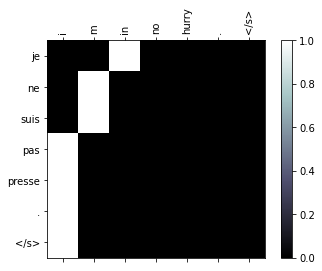

In [39]:
show_attention(input_, pred, attn)

# TODO 

* BLEU
* Beam Search
* <a href="http://www.aclweb.org/anthology/P15-1001">Sampled Softmax</a>

## Further topics

* <a href="https://s3.amazonaws.com/fairseq/papers/convolutional-sequence-to-sequence-learning.pdf">Convolutional Sequence to Sequence learning</a>
* <a href="https://arxiv.org/abs/1706.03762">Attention is all you need</a>
* <a href="https://arxiv.org/abs/1711.00043">Unsupervised Machine Translation Using Monolingual Corpora Only</a>

## Suggested Reading 

* <a href="https://arxiv.org/pdf/1709.07809.pdf">SMT chapter13. Neural Machine Translation</a>